In [1]:
import numpy as np
from math import erfc, sqrt
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Transmitter
def BinarySource(n):
    """
    This function generates a 1-dimensional numpy array of random binary values (0 or 1) with a specified length.
    """
    return np.random.randint(0, 2, n)


In [3]:
def binarycode_to_signal(bitstream, step):
    """
    This function converts a binary code into a signal waveform using pulse amplitude modulation (PAM) with polar non-return-to-zero (NRZ) coding. The function takes a binary bitstream and a step size as input and returns a PAM signal waveform.
    """
    T = 1
    A = 1
    pulse = np.ones(int(T/step))
    pulse = pulse*A
    signal = np.zeros(len(bitstream)*len(pulse))
    # Polar nonreturn to zero
    for i in range(len(bitstream)):
        if bitstream[i] == 1:
            # take the shape of pulse along the symbol's interval
            signal[i*len(pulse):(i+1)*len(pulse)] = 1*pulse
        else:
            signal[i*len(pulse):(i+1)*len(pulse)] = -1*pulse
    return signal


In [4]:
# Channel
# Add noise
def AWGN(n, sigma):
    """
    This function generates a 1-dimensional numpy array of n samples of additive white Gaussian noise (AWGN) with zero mean and a specified standard deviation sigma.
    """
    return np.random.normal(0, sigma, n)


In [5]:
# Receiver

def receive_filter(signal_noise, filter_num, step):
    """
    This function receives a noisy signal and applies a filter to it based on the given filter number. The output is the filtered signal.
    """
    filter_num -= 1
    filters = [np.ones(int(1/step)), np.ones(1),
               np.sqrt(3)*np.arange(0, 1, step)]
    filter = filters[filter_num]
    filter = np.concatenate((filter, np.zeros(int(1/step)-len(filter))))
    signal_noise_filter = np.convolve(signal_noise, filter)
    if (filter_num == 0 or filter_num == 2):
        signal_noise_filter = signal_noise_filter*step
    return signal_noise_filter


In [6]:
def sampler(sampling_period, signal_noise_filtered, n=10):
    """
    This function takes a signal with noise that has been filtered, and samples it every "sampling_period" to obtain "n" samples. It returns an array with the sampled values.
    """
    samples = np.zeros(n)
    for i in range(len(samples)):
        samples[i] = signal_noise_filtered[sampling_period-1+i*sampling_period]
    return samples


In [7]:
def Q(x):
    """
    This function returns the value of the Q function for a given input x, which is defined as half the complementary error function (erfc) of x divided by the square root of 2.
    """
    return 0.5 * erfc(x/sqrt(2))


In [8]:
def decision_maker(samples, lambd):
    """
    This function takes in a set of samples and a decision threshold 'lambda' and returns a binary sequence of the same length as the input samples, where each bit is 1 if the corresponding sample is greater than the threshold, and 0 otherwise.
    """
    return (samples > lambd)*1


In [9]:
# variance is the noise's variance and f is the filter's E_N. (1 or 2 or 3)
def compute_BER(variance, f):
    """
    This function computes the bit error rate (BER) of a received signal, given its noise variance and filter's E_N (energy per symbol to noise power spectral density). It generates AWGN noise, adds it to the signal, applies a filter, samples the filtered signal, decodes the samples and compares them with the original to compute the probability of error.
    """
    # generate the noise
    w_t = AWGN(len(g_t), variance)

    # add the Nise to the signal (3)
    s_t = g_t + w_t

    # apply the filter to the signal (4)
    y_t = receive_filter(s_t, f, step)

    # sample the filtered signal (5)
    sampling_period = int(T/step)
    # y_T has all samples
    y_iT = sampler(sampling_period, y_t, n)

    # decode the samples (6)
    # holds for all 3 cases.
    lambd = 0
    bitstream_output = decision_maker(y_iT, lambd)

    # compare the resulting bitstream with the original to compute the probability of error
    return np.sum(input_bitstream != bitstream_output)/len(input_bitstream)


In [10]:

n = 10
step = 0.05  # one pulse of duration 1 has 20 samples
t = np.arange(0, n, step)

sigma_noise = 0.1            # relates to the channel noise.
filter_num = 1
# generate the binary symbols
bitstream = BinarySource(n)
print("Bitstream: ", bitstream)


Bitstream:  [0 1 1 1 0 0 0 0 0 0]


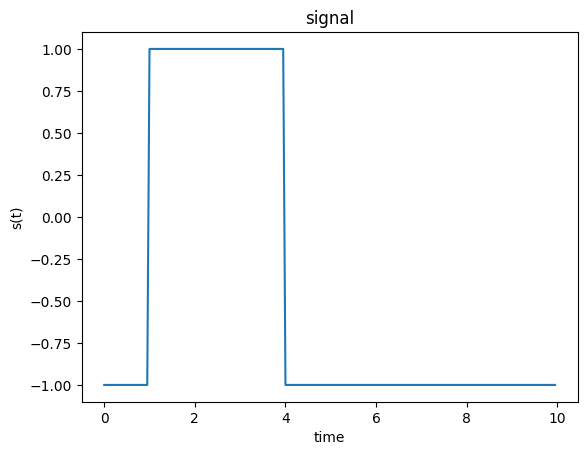

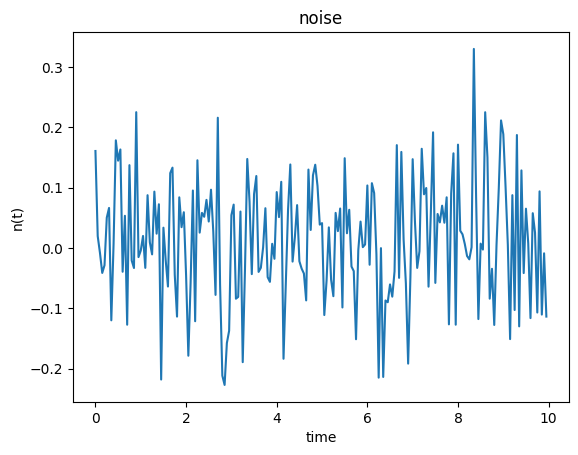

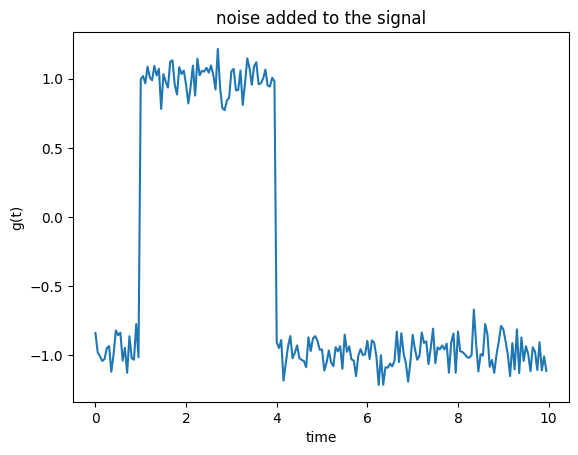

In [11]:
signal = binarycode_to_signal(bitstream, step)
plt.plot(t, signal)
plt.xlabel('time')
plt.ylabel('s(t)')
plt.title('signal')
plt.show()

# generate the noise
noise = AWGN(len(signal), sigma_noise)

plt.plot(t, noise)
plt.xlabel('time')
plt.ylabel('n(t)')
plt.title('noise')
plt.show()

# add the noise to the signal
signal_noise = signal+noise
plt.plot(t, signal_noise)
plt.xlabel('time')
plt.ylabel('g(t)')
plt.title('noise added to the signal')
plt.show()


Reconstructed Bitstram: [0 1 1 1 0 0 0 0 0 0]
Total number of bits: 10
Received Wrong: 0
BER: 0.0


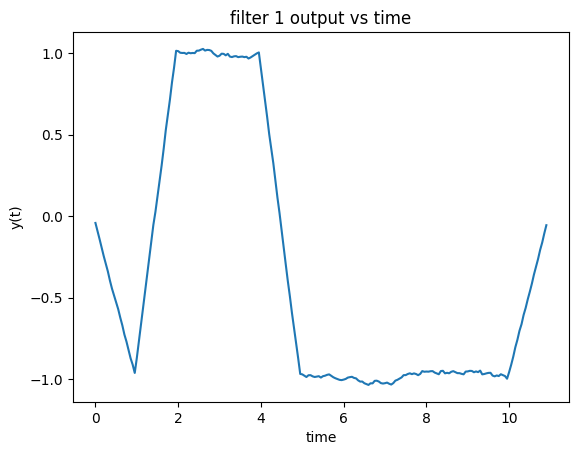

In [12]:

filter_num = 1
signal_noise_filter = receive_filter(signal_noise, filter_num, step)
plt.plot(np.arange(0, len(signal_noise_filter)*step, step), signal_noise_filter)
plt.xlabel('time')
plt.ylabel('y(t)')
plt.title('filter ' + str(filter_num) + ' output vs time')
plt.savefig('filter_' + str(filter_num) + '_output.jpg')

# sample the filtered signal
sampling_period = int(1/step)
samples = sampler(sampling_period, signal_noise_filter)
# decode the samples
reconstructed_bitstram = decision_maker(samples, 0)
print('Reconstructed Bitstram:', reconstructed_bitstram)
print("Total number of bits:", len(bitstream))
print("Received Wrong:", np.sum(bitstream != reconstructed_bitstram))
print("BER:", np.sum(bitstream != reconstructed_bitstram)/len(bitstream))


Reconstructed Bitstram: [0 1 1 1 0 0 0 0 0 0]
Total number of bits: 10
Received Wrong: 0
BER: 0.0


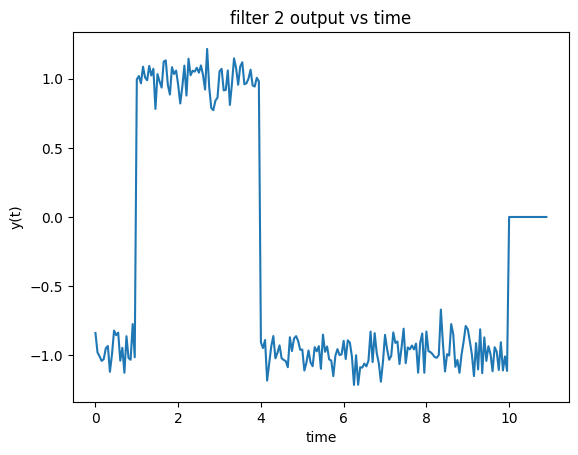

In [13]:

filter_num = 2
signal_noise_filter = receive_filter(signal_noise, filter_num, step)
plt.plot(np.arange(0, len(signal_noise_filter)*step, step), signal_noise_filter)
plt.xlabel('time')
plt.ylabel('y(t)')
plt.title('filter ' + str(filter_num) + ' output vs time')
plt.savefig('filter_' + str(filter_num) + '_output.jpg')

# sample the filtered signal
sampling_period = int(1/step)
samples = sampler(sampling_period, signal_noise_filter)
# decode the samples
reconstructed_bitstram = decision_maker(samples, 0)
print('Reconstructed Bitstram:', reconstructed_bitstram)
print("Total number of bits:", len(bitstream))
print("Received Wrong:", np.sum(bitstream != reconstructed_bitstram))
print("BER:", np.sum(bitstream != reconstructed_bitstram)/len(bitstream))


Reconstructed Bitstram: [0 1 1 1 0 0 0 0 0 0]
Total number of bits: 10
Received Wrong: 0
BER: 0.0


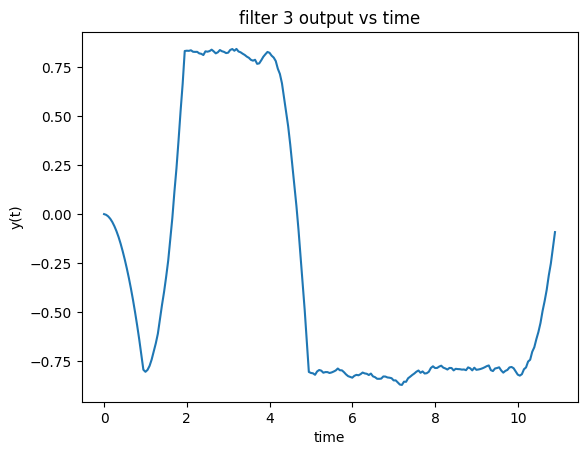

In [14]:

filter_num = 3
signal_noise_filter = receive_filter(signal_noise, filter_num, step)
plt.plot(np.arange(0, len(signal_noise_filter)*step, step), signal_noise_filter)
plt.xlabel('time')
plt.ylabel('y(t)')
plt.title('filter ' + str(filter_num) + ' output vs time')
plt.savefig('filter_' + str(filter_num) + '_output.jpg')

# sample the filtered signal
sampling_period = int(1/step)
samples = sampler(sampling_period, signal_noise_filter)
# decode the samples
reconstructed_bitstram = decision_maker(samples, 0)
print('Reconstructed Bitstram:', reconstructed_bitstram)
print("Total number of bits:", len(bitstream))
print("Received Wrong:", np.sum(bitstream != reconstructed_bitstram))
print("BER:", np.sum(bitstream != reconstructed_bitstram)/len(bitstream))


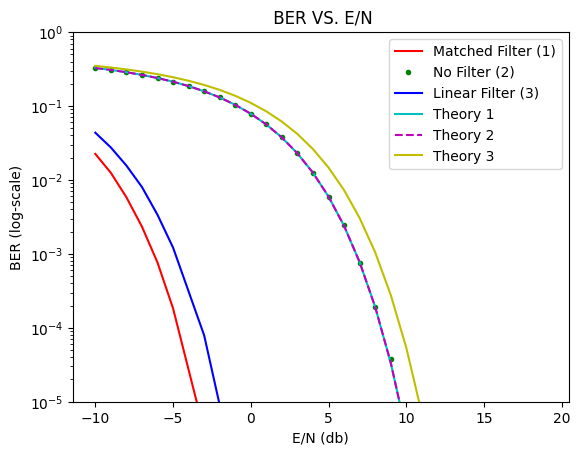

In [15]:

n = 1000000  # bitstream length

step = 0.05  # 20 Samples per pulse of duration 1
T = 1

# generate the binary symbols
input_bitstream = BinarySource(n)

# generate the binary signal
g_t = binarycode_to_signal(input_bitstream, step)

# plot BER VS. E/No for each filter
E_N = np.arange(-10, 20, 1)
N = 1/(10**(E_N/10))
# the corresponding range of sigma.
variance = np.sqrt(N/2)


# Filter 1:
filter1_BER, filter1_BER_th = np.zeros(len(variance)), np.zeros(len(variance))
for i in range(len(variance)):
    filter1_BER[i] = compute_BER(variance[i], 1)
    filter1_BER_th[i] = Q(1/variance[i])

# Filter 2:
filter2_BER, filter2_BER_th = np.zeros(len(variance)), np.zeros(len(variance))
for i in range(len(variance)):
    filter2_BER[i] = compute_BER(variance[i], 2)
    filter2_BER_th[i] = Q(1/variance[i])

# Filter 3:
filter3_BER, filter3_BER_th = np.zeros(len(variance)), np.zeros(len(variance))
for i in range(len(variance)):
    filter3_BER[i] = compute_BER(variance[i], 3)
    filter3_BER_th[i] = Q(np.sqrt(3)/2*1/variance[i])

plt.semilogy(E_N, filter1_BER, 'r')
plt.semilogy(E_N, filter2_BER, 'g.')
plt.semilogy(E_N, filter3_BER, 'b')
plt.semilogy(E_N, filter1_BER_th, 'c')
plt.semilogy(E_N, filter2_BER_th, 'm--')
plt.semilogy(E_N, filter3_BER_th, 'y')

plt.xlabel('E/N (db)')
plt.ylabel('BER (log-scale)')
plt.title(' BER VS. E/N')
plt.legend(['Matched Filter (1)', 'No Filter (2)',
           'Linear Filter (3)', 'Theory 1', 'Theory 2', 'Theory 3'])
plt.ylim([10/(n), 1])
plt.savefig('./BitErrorRate.png')


In [16]:
""" 
The Bit Error Rate (BER) decreases as the energy per bit (E) relative to the noise power spectral density (No) increases, which is evident in the plot. This can be explained in various ways:

Using the theoretical expression for BER and noting that the Q function is a decreasing function, it is apparent that Q(a * sqrt(E/No)) for all the cases mentioned in the problem. Therefore, as sqrt is an increasing function, it can be concluded that BER is a decreasing function of E/No.
"""

""" 
The case that uses a matched filter has the lowest BER because it employs a filter that is specifically designed to minimize the probability of error by matching the filter to the pulse. By doing so, the matched filter maximizes the peak pulse SNR at the sampling instant, which helps reduce the probability of error.

It is important to note that in the theoretical case, using a filter or not yields the same expression due to our assumptions on variance and PSD.
"""

' \nThe case that uses a matched filter has the lowest BER because it employs a filter that is specifically designed to minimize the probability of error by matching the filter to the pulse. By doing so, the matched filter maximizes the peak pulse SNR at the sampling instant, which helps reduce the probability of error.\n\nIt is important to note that in the theoretical case, using a filter or not yields the same expression due to our assumptions on variance and PSD.\n'